# Survival analysis

In [2]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [3]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [5]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

**Survival analysis** is a way to describe how long things last.
It is often used to study human lifetimes, but it also applies to "survival" of mechanical and electronic components, or more generally to intervals in time before an event.

If someone you know has been diagnosed with a life-threatening disease, you might have seen a "5-year survival rate," which is the probability of surviving five years after diagnosis.
That estimate and related statistics are the result of survival analysis.

## Survival curves

The fundamental concept in survival analysis is the **survival curve**, $S(t)$, which is a function that maps from a duration, $t$, to the probability of surviving longer than $t$.
If you know the distribution of durations, or "lifetimes", finding the survival curve is easy; it's just the complement of the CDF: 

$$S(t) = 1 - CDF(t)$$ 

where $CDF(t)$ is the probability of a lifetime less than or equal to $t$.

For example, in the NSFG dataset, we know the duration of 11,189 complete pregnancies.
We can read this data and compute the CDF:

In [22]:
download(
    "https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv"
)

Downloaded lamps.csv


<IPython.core.display.Javascript object>

In [23]:
df = pd.read_csv("lamps.csv", index_col=0)
df.tail()

,h,f,K
i,,,
28,1812,1,4
29,1836,1,3
30,1860,1,2
31,1980,1,1
32,2568,1,0


<IPython.core.display.Javascript object>

In [34]:
from empiricaldist import Pmf

pmf_bulblife = Pmf(df["f"].values, index=df["h"])
pmf_bulblife.normalize()
pmf_bulblife.index.name = "t"

<IPython.core.display.Javascript object>

In [42]:
cdf_bulblife = pmf_bulblife.make_cdf()
cdf_bulblife[1656]

0.7800000000000002

<IPython.core.display.Javascript object>

In [46]:
complementary_cdf = 1 - cdf_bulblife
complementary_cdf[1656]

0.21999999999999975

<IPython.core.display.Javascript object>

In [47]:
# surv_bulblife[1657]

<IPython.core.display.Javascript object>

In [48]:
surv_bulblife = cdf_bulblife.make_surv()
surv_bulblife[1656]

0.21999999999999997

<IPython.core.display.Javascript object>

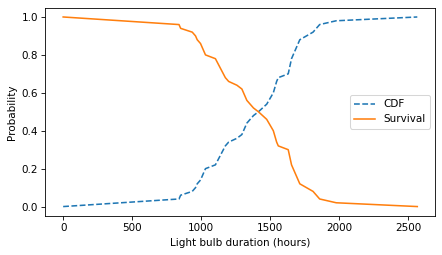

<IPython.core.display.Javascript object>

In [233]:
cdf_bulblife.plot(ls="--", label="CDF")
surv_bulblife.plot(label="Survival")

decorate(xlabel="Light bulb duration (hours)", ylabel="Probability")

In [53]:
hazard = pmf_bulblife / (pmf_bulblife + surv_bulblife)
hazard[1656]

0.15384615384615388

<IPython.core.display.Javascript object>

In [58]:
hazard_bulblife = surv_bulblife.make_hazard()
hazard_bulblife[1656]

0.15384615384615397

<IPython.core.display.Javascript object>

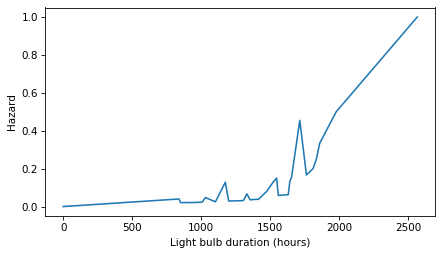

<IPython.core.display.Javascript object>

In [59]:
hazard_bulblife.plot()
decorate(xlabel="Light bulb duration (hours)", ylabel="Hazard")

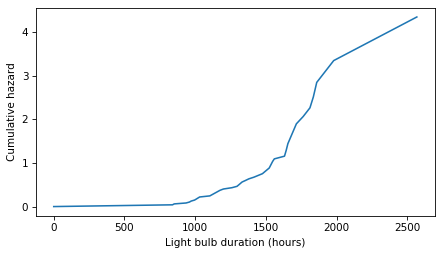

<IPython.core.display.Javascript object>

In [61]:
cumulative_hazard = hazard_bulblife.cumsum()
cumulative_hazard.plot()

decorate(xlabel="Light bulb duration (hours)", ylabel="Cumulative hazard")

## Marriage Data

In [68]:
filename = "marriage_nsfg_female.csv.gz"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

<IPython.core.display.Javascript object>

In [69]:
resp = pd.read_csv(filename)
resp.shape

(70183, 40)

<IPython.core.display.Javascript object>

Marriage data

-   `cmbirth`: The respondent's date of birth, known for all respondents.

-   `cmintvw`: The date the respondent was interviewed, known for all respondents.

-   `cmmarrhx`: The date the respondent was first married, if applicable and known.

-   `evrmarry`: 1 if the respondent had been married prior to the date of interview, 0 otherwise.

The first three variables are encoded in "century-months"; that is, the integer number of months since December 1899.
So century-month 1 is January 1900.

In [70]:
month0 = pd.to_datetime("1899-12-31")


def decade_of_birth(cmbirth):
    date = month0 + pd.DateOffset(months=cmbirth)
    return date.year // 10 * 10

<IPython.core.display.Javascript object>

In [71]:
from thinkstats import value_counts

resp["cohort"] = resp["cmbirth"].apply(decade_of_birth)
value_counts(resp["cohort"])

cohort
1930      325
1940     3608
1950    10631
1960    15064
1970    16466
1980    14318
1990     8539
2000     1232
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [72]:
value_counts(resp["cmmarrhx"])

cmmarrhx
626.0         1
628.0         1
629.0         1
630.0         1
639.0         2
          ...  
1392.0      203
1404.0      117
1416.0       55
1428.0       13
NaN       33682
Name: count, Length: 746, dtype: int64

<IPython.core.display.Javascript object>

Then we compute each respondent's age when married and age when interviewed:

In [82]:
resp["agemarr"] = (resp["cmmarrhx"] - resp["cmbirth"]) / 12
resp["age"] = (resp["cmintvw"] - resp["cmbirth"]) / 12

<IPython.core.display.Javascript object>

In [83]:
grouped = resp.groupby("cohort")
for name, group in grouped:
    print(name, len(group))

1930 325
1940 3608
1950 10631
1960 15064
1970 16466
1980 14318
1990 8539
2000 1232


<IPython.core.display.Javascript object>

In [321]:
from empiricaldist import Surv


def make_survival_curves(resp, cohorts):
    curve_map = {}

    grouped = resp.groupby("cohort")
    for cohort in cohorts:
        group = grouped.get_group(cohort)
        curve_map[cohort] = Surv.from_seq(group["agemarr"], dropna=False)

    return curve_map

<IPython.core.display.Javascript object>

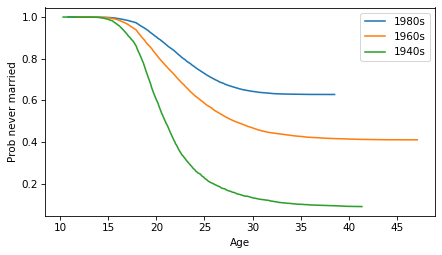

<IPython.core.display.Javascript object>

In [323]:
cohorts = [1980, 1960, 1940]
curve_map = make_survival_curves(resp, cohorts)

for cohort, curve in curve_map.items():
    curve.plot(label=f"{cohort}s")

decorate(xlabel="Age", ylabel="Prob never married")

The problem is that these are totally wrong

## Weighted resampling

In [105]:
from thinkstats import resample_rows_weighted


def resample_cycles(resp):
    grouped = resp.groupby("cycle")
    samples = [resample_rows_weighted(group, column="finalwgt") for _, group in grouped]
    return pd.concat(samples)

<IPython.core.display.Javascript object>

In [106]:
sample = resample_cycles(resp)

<IPython.core.display.Javascript object>

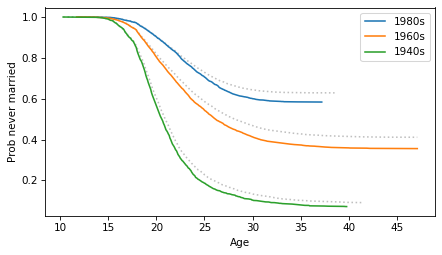

<IPython.core.display.Javascript object>

In [108]:
for label, curve in curves.items():
    curve.plot(ls=":", color="gray", alpha=0.5)

curves_resampled = make_survival_curves(sample, cohorts)

for label, curve in curves_resampled.items():
    curve.plot(label=label)

decorate(xlabel="Age", ylabel="Prob never married")

## Inferring survival curves

If someone gives you the CDF of lifetimes, it is easy to compute the survival and hazard functions.
But in many real-world scenarios, we can't measure the distribution of lifetimes directly.
We have to infer it.

For example, suppose you are following a group of patients to see how long they survive after diagnosis.
Not all patients are diagnosed on the same day, so at any point in time, some patients have survived longer than others.
If some patients have died, we know their survival times.
For patients who are still alive, we don't know survival times, but we have a lower bound.

If we wait until all patients are dead, we can compute the survival curve, but if we are evaluating the effectiveness of a new treatment, we can't wait that long! We need a way to estimate survival curves using incomplete information.

As a more cheerful example, I will use NSFG data to quantify how long respondents "survive" until they get married for the first time.
The range of respondents' ages is 14 to 44 years, so the dataset provides a snapshot of women at different stages in their lives.

For women who have been married, the dataset includes the date of their first marriage and their age at the time.
For women who have not been married, we know their age when interviewed, but have no way of knowing when or if they will get married.

Since we know the age at first marriage for *some* women, it might be tempting to exclude the rest and compute the CDF of the known data.
That is a bad idea.
The result would be doubly misleading: (1) older women would be overrepresented, because they are more likely to be married when interviewed, and (2) married women would be overrepresented! In fact, this analysis would lead to the conclusion that all women get married, which is obviously incorrect.

## Kaplan-Meier estimation

In this example it is not only desirable but necessary to include observations of unmarried women, which brings us to one of the central algorithms in survival analysis, **Kaplan-Meier estimation**.

The general idea is that we can use the data to estimate the hazard function, then convert the hazard function to a survival curve.
To estimate the hazard function, we consider, for each age, (1) the number of women who got married at that age and (2) the number of women "at risk" of getting married, which includes all women who were not married at an earlier age.

Here's the code:

In [187]:
resp60 = sample.query("cohort == 1960")

<IPython.core.display.Javascript object>

In [188]:
complete = resp60.query("evrmarry == 1")["agemarry"].dropna()
len(complete)

10046

<IPython.core.display.Javascript object>

In [189]:
ongoing = resp60.query("evrmarry == 0")["age"]
len(ongoing)

5522

<IPython.core.display.Javascript object>

In [273]:
from empiricaldist import Hist

hist_complete = Hist.from_seq(complete)
hist_ongoing = Hist.from_seq(ongoing)

<IPython.core.display.Javascript object>

In [274]:
hist_complete[25]

75

<IPython.core.display.Javascript object>

In [275]:
hist_ongoing[25]

11

<IPython.core.display.Javascript object>

In [276]:
surv_complete = hist_complete.make_surv()
surv_ongoing = hist_ongoing.make_surv()

<IPython.core.display.Javascript object>

In [277]:
surv_complete[25]

2927

<IPython.core.display.Javascript object>

In [278]:
surv_ongoing[25]

2261

<IPython.core.display.Javascript object>

In [279]:
at_risk = hist_complete[25] + hist_ongoing[25] + surv_complete[25] + surv_ongoing[25]
at_risk

5274

<IPython.core.display.Javascript object>

In [280]:
hazard = hist_complete[25] / at_risk
hazard

0.01422070534698521

<IPython.core.display.Javascript object>

In [281]:
ts = pd.Index.union(hist_complete.index, hist_ongoing.index)
len(ts)

383

<IPython.core.display.Javascript object>

In [282]:
at_risk = hist_complete(ts) + hist_ongoing(ts) + surv_complete(ts) + surv_ongoing(ts)
len(at_risk)

383

<IPython.core.display.Javascript object>

In [283]:
hs = hist_complete(ts) / at_risk
len(hs)

383

<IPython.core.display.Javascript object>

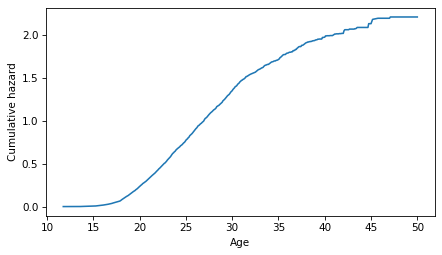

<IPython.core.display.Javascript object>

In [284]:
from empiricaldist import Hazard

hazard = Hazard(hs, ts)
hazard.cumsum().plot()

decorate(xlabel="Age", ylabel="Cumulative hazard")

In [285]:
ps = (1 - hazard).cumprod()

<IPython.core.display.Javascript object>

In [286]:
surv = hazard.make_surv()

<IPython.core.display.Javascript object>

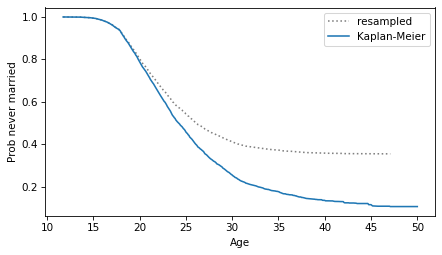

<IPython.core.display.Javascript object>

In [287]:
curves_resampled[1960].plot(ls=':', color='gray', label="resampled")
surv.plot(label="Kaplan-Meier")

decorate(xlabel="Age", ylabel="Prob never married")

In [300]:
def estimate_hazard(complete, ongoing):
    """Kaplan-Meier estimation."""
    hist_complete = Hist.from_seq(complete)
    hist_ongoing = Hist.from_seq(ongoing)

    surv_complete = hist_complete.make_surv()
    surv_ongoing = hist_ongoing.make_surv()

    ts = pd.Index.union(hist_complete.index, hist_ongoing.index)
    at_risk = (
        hist_complete(ts) + hist_ongoing(ts) + surv_complete(ts) + surv_ongoing(ts)
    )

    hs = hist_complete(ts) / at_risk
    return Hazard(hs, ts)

<IPython.core.display.Javascript object>

In [305]:
def estimate_survival(group):
    """Estimate the survival curve."""
    complete = group.query("evrmarry == 1")["agemarry"].dropna()
    ongoing = group.query("evrmarry == 0")["age"]
    hf = estimate_hazard(complete, ongoing)
    sf = hf.make_surv()
    return sf

<IPython.core.display.Javascript object>

In [309]:
surv = estimate_survival(resp60)

<IPython.core.display.Javascript object>

In [310]:
try:
    import lifelines
except ImportError:
    !pip install lifelines

<IPython.core.display.Javascript object>

In [311]:
from lifelines import KaplanMeierFitter

all_times = np.concatenate([complete, ongoing])

# 1 for complete cases, 0 for ongoing (censored) cases
event_observed = np.concatenate([np.ones(len(complete)), np.zeros(len(ongoing))])

kmf = KaplanMeierFitter()
kmf.fit(durations=all_times, event_observed=event_observed)

ps = kmf.survival_function_["KM_estimate"].drop(0)
np.allclose(ps, surv)

True

<IPython.core.display.Javascript object>

A curve like this was the basis of a famous magazine article in 1986; *Newsweek* reported that a 40-year old unmarried woman was "more likely to be killed by a terrorist" than get married.
These statistics were widely reported and became part of popular culture, but they were wrong then (because they were based on faulty analysis) and turned out to be even more wrong (because of cultural changes that were already in progress and continued).
In 2006, *Newsweek* ran an another article admitting that they were wrong.

I encourage you to read more about this article, the statistics it was based on, and the reaction.
It should remind you of the ethical obligation to perform statistical analysis with care, interpret the results with appropriate skepticism, and present them to the public accurately and honestly.

## Confidence intervals

Kaplan-Meier analysis yields a single estimate of the survival curve, but it is also important to quantify the uncertainty of the estimate.
As usual, there are three possible sources of error: measurement error, sampling error, and modeling error.

In this example, measurement error is probably small.
People generally know when they were born, whether they've been married, and when.
And they can be expected to report this information accurately.

We can quantify sampling error by resampling.
Here's the code:

In [324]:
def make_survival_curves(resp, cohorts):
    curve_map = {}

    grouped = resp.groupby("cohort")
    for cohort in cohorts:
        group = grouped.get_group(cohort)
        curve_map[cohort] = estimate_survival(group)

    return curve_map

<IPython.core.display.Javascript object>

In [329]:
curve_maps = [make_survival_curves(resample_cycles(resp), cohorts) for i in range(101)]

<IPython.core.display.Javascript object>

In [334]:
def plot_cohort(curve_maps, cohort, color):
    curves = [curve_map[cohort] for curve_map in curve_maps]
    for curve in curves:
        curve.plot(color=color, alpha=0.05)

<IPython.core.display.Javascript object>

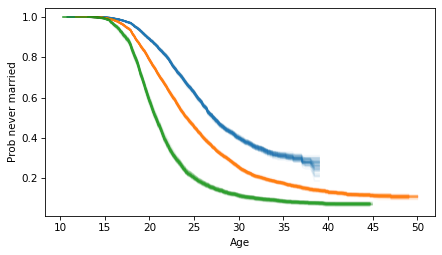

<IPython.core.display.Javascript object>

In [336]:
colors = ["C0", "C1", "C2"]
for cohort, color in zip(cohorts, colors):
    plot_cohort(curve_maps, cohort, color)

decorate(xlabel="Age", ylabel="Prob never married")

Several patterns are visible:

-   Women born in the 50s married earliest, with successive cohorts marrying later and later, at least until age 30 or so.

-   Women born in the 60s follow a surprising pattern.
Prior to age 25, they were marrying at slower rates than their predecessors.
After age 25, they were marrying faster.
By age 32 they had overtaken the 50s cohort, and at age 44 they are substantially more likely to have married.

Women born in the 60s turned 25 between 1985 and 1995.
Remembering that the *Newsweek* article I mentioned was published in 1986, it is tempting to imagine that the article triggered a marriage boom.
That explanation would be too pat, but it is possible that the article and the reaction to it were indicative of a mood that affected the behavior of this cohort.

-   The pattern of the 70s cohort is similar.
They are less likely than their predecessors to be married before age 25, but at age 35 they have caught up with both of the previous cohorts.

-   Women born in the 80s are even less likely to marry before age 25. What happens after that is not clear; for more data, we have to wait for the next cycle of the NSFG.

In the meantime we can make some predictions.

## Expected remaining lifetime

Given a survival curve, we can compute the expected remaining lifetime as a function of current age.
For example, given the survival curve of pregnancy length, we can compute the expected time until delivery.

The first step is to extract the PMF of lifetimes.
`SurvivalFunction` provides a method that does that:

The following cells download the data files and install `statadict`, which we need to read the data.

In [337]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [338]:
try:
    import statadict
except ImportError:
    !pip install statadict

<IPython.core.display.Javascript object>

In [339]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

<IPython.core.display.Javascript object>

In [340]:
# TODO: compute remaining lifetimes

<IPython.core.display.Javascript object>

For example, during Week 0, the expected remaining duration is about 34 weeks.
That's less than full term (39 weeks) because terminations of pregnancy in the first trimester bring the average down.

The curve drops slowly during the first trimester.
After 13 weeks, the expected remaining lifetime has dropped by only 9 weeks, to 25. After that the curve drops faster, by about a week per week.

Between Week 37 and 42, the curve levels off between 1 and 2 weeks.
At any time during this period, the expected remaining lifetime is the same; with each week that passes, the destination gets no closer.
Processes with this property are called **memoryless** because the past has no effect on the predictions.
This behavior is the mathematical basis of the infuriating mantra of obstetrics nurses: "Any day now."

## Glossary

-   **survival analysis**: A set of methods for describing and predicting lifetimes, or more generally time until an event occurs.

-   **survival curve**: A function that maps from a time, $t$, to the probability of surviving past $t$.

-   **hazard function**: A function that maps from $t$ to the fraction of people alive until $t$ who die at $t$.

-   **Kaplan-Meier estimation**: An algorithm for estimating hazard and survival functions.

-   **cohort**: a group of subjects defined by an event, like date of birth, in a particular interval of time.

-   **cohort effect**: a difference between cohorts.

-   **NBUE**: A property of expected remaining lifetime, "New better than used in expectation."

-   **UBNE**: A property of expected remaining lifetime, "Used better than new in expectation."

## Exercises

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing.
Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)